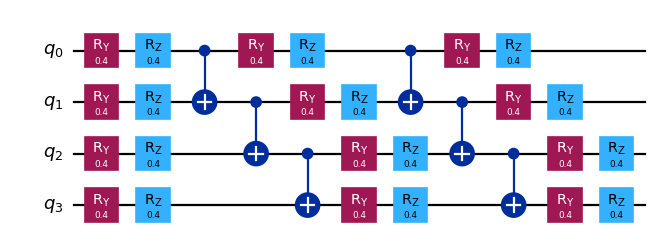

In [3]:
from qiskit.circuit.library import EfficientSU2

qc = EfficientSU2(4, entanglement='linear', reps=2).decompose()
qc.assign_parameters([0.4]*len(qc.parameters), inplace=True)

qc.draw('mpl', scale=0.8)

In [4]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

In [9]:
# Separation of the circuit and observable according to a specified quantum partitioning

from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(circuit=qc, partition_labels="AABB", observables=observable.paulis)
subcircuits = partitioned_problem.subcircuits 
subobservables = partitioned_problem.subobservables 
bases = partitioned_problem.bases

# Visualization 

subobservables 

{'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']),
 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}

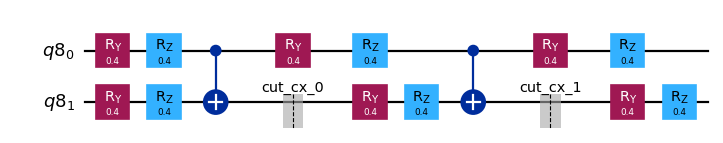

In [10]:
subcircuits["A"].draw('mpl', scale=0.8)

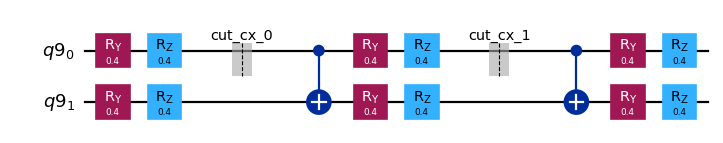

In [11]:
subcircuits["B"].draw('mpl', scale=0.8)

In [12]:
# Calculating sampling overheads for the chosen cuts 

import numpy as np 

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 81.0


In [13]:
# Subexperiments 

from qiskit_addon_cutting import generate_cutting_experiments 

subexperiments, coefficients = generate_cutting_experiments(circuits=subcircuits, observables=subobservables, num_samples=np.inf)

In [15]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeManilaV2()

# Transpilation 
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {label: pass_manager.run(partition_subexpts) for label, partition_subexpts in subexperiments.items()}

In [25]:
# Execution and post-processing 

from qiskit_ibm_runtime import SamplerV2, Batch 
from qiskit_aer.primitives import EstimatorV2
from qiskit_addon_cutting import reconstruct_expectation_values

# Execute each partition's subexperiment back-to-back
with Batch(backend=backend) as batch: 
    sampler = SamplerV2(mode=batch)
    jobs = {label: sampler.run(subsystem_subexpts, shots=2**12) for label, subsystem_subexpts in isa_subexperiments.items()}
    
results = {label: job.result() for label, job in jobs.items()}

# Retrive expectation of each observable 
reconstructed_expval_terms = reconstruct_expectation_values(results, coefficients, subobservables,)

# Evaluate final expectation value 
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)


estimator = EstimatorV2()
exact_expval = estimator.run([(qc, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}")

Reconstructed expectation value: 0.55530858
Exact expectation value: 0.56254612
Error in estimation: -0.00723754
Relative error in estimation: -0.01286569
